# Final Project - Criteo Labs Display Advertising Challenge
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

__`Team: Chi Iong Ansjory, Catherine Cao, Scott Xu`__

Table of Content:
- [0. Background](#background)
- [1. Question Formulation](#question_formulation)
- [2. Algorithm Explanation](#algorithm_explanation)
- [3. EDA & Discussion of Challenges](#eda_challenges)
- [4. Algorithm Implementation](#algorithm_implementation)
- [5. Application of Course Concepts](#course_concepts_application)

<a id='background'></a>
# 0. Background

Criteo Labs is a leading global technology company that specializes in performance display advertising, working with over 4,000 e-commerce companies around the world. Their technology takes an algorithmic approach to determining what user they show an advertisement to, when, and for what products. For billions of unique advertisements that are created and displayed at lightning fast speeds every day.

Display advertising is a billion dollar effort and one of the central uses of Machine Learning on the Internet. However, its data and methods are usually kept confidential. Through the Kaggle research competition, Criteo Labs is sharing a week’s worth of data for participants to develop models predicting advertisement click-through rate (CTR). Given a user and the page being visited, what is the probability that the user will click on a given advertisement?

Source: https://www.kaggle.com/c/criteo-display-ad-challenge

For the dataset, the smaller version is no longer available from Kaggle. The full-size version needs to be used instead from Criteo Labs.

Source: https://www.kaggle.com/c/criteo-display-ad-challenge/data (smaller version - obsoleted); http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/ (full-size version)

### Notebook Set-Up

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

import os

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
MAX_MEMORY = "64g"
app_name = "fpj_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .config("spark.executor.memory", MAX_MEMORY)\
        .config("spark.driver.memory", MAX_MEMORY) \
        .getOrCreate()
sc = spark.sparkContext

from pyspark.sql.types import *
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F

<a id='question_formulation'></a>
# 1. Question Formulation

The goal of this analysis is to benchmark the most accurate ML algorithms for CTR estimation.

Understanding the drivers of what influences an individual user to click on a link or not has billions of dollars worth of implications. If we are able to develop a model that predicts user click through rates, the digital advertising market could become more efficient as billions of dollars is wasted annually on mistargeted users. Search engine marketers and analysts frequently perform this type of analysis to reduce one of the most expensive elements of eCommerce, which is called the Cost of Acquisition, or CAC. Particularly for SaaS and digital goods and services, CAC can constitute the majority of costs of goods sold. By being able to target interested customers better, thereby reducing the CAC of a product, less ad-spend goes wasted and the profit margins on each unit sold increases. Consequently businesses have a strong interest in ensuring that ads are properly targeted and CTRs are high.

In an ideal world with perfect information, we would be able to serve up advertisements that have a 100% CTR; that is, each ad we serve results in a click. This would then enable us to focus on conversion tactics that follow the initial ad click. According to WordStream, an online advertising consultancy, a CTR of over 2% for a search advertisement would be terrific. Typically, CTRs are divided up by industry, as each industry's customer has a different profile. For Display Advertisements, which is what Criteo primarily sells, a CTR of above 0.4% would be very good, again, depending on industry.

Source: https://www.wordstream.com/average-ctr

<a id='algorithm_explanation'></a>
# 2. Algorithm Explanation

Based on the volume of the full-size dataset (11GB), we decided to leverage PySpark and Spark ML Library (MLLib) packages. In addressing our project question of correctly predicting CTR, we evaluated following 3 algorithms: Logistic Regression (LR), Gradient Boosted Tree (GBT), and Random Forest (RF).

Source: https://spark.apache.org/docs/2.3.0/ml-guide.html

Logistic Regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. If we model this sample data with a logistic regression, we assume that there are parameters $\beta_1$ to $\beta_{22}$ that:

$$ y(clicked) = \frac{exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_{22} x_{22})}{1 + exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_{22} x_{22})} $$

This is in the matrix form of:

$$ \theta^T = \big[ \beta_0 \beta_1 ... \beta_{22} \big] $$

Let sigmoid function $G(z)$ be:

$$ G(z) = \frac{1}{1 + e^{-z}} $$

Each prediction will be:

$$ y_i = G(x_i \theta^T) $$

The log loss function for the logistic regression is defined as:

$$ J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} (y_i log(H(x_i)) - (1-y_i)log(1-H(x_i)))$$

We can think of the log loss function as the error of our predictions and the process of solving for $\beta$'s as to minimize the log loss function. In order to do that, we can use the method of gradient descent where we iteratively adjust the coefficients $\theta$ to the direction that decreases the log loss function. The direction is given to us by the derivative of the log loss function.

Taking a derivative of the log loss function with respect to $\theta$ to get the gradient:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (H(x_i)-y_i) * x_{ij}$$

With the gradient computed in every iteration, we get the next $\theta$ by:

$$ \theta_{new} = \theta - \alpha * \frac{\partial J(\theta)}{\partial \theta_j} $$

where $\alpha$ is the learning rate for the gradient descent

To illustrate math calculations, randomly pick 5 samples from __train.txt__ as toy example with 2 numeric columns (x1, x2) and 1 one-hot encoded categorical column (x3) 

| y | x1 | x2 | x3 |
|---|----|----|----|
| 0 | 1  | 2  | 1  | 
| 0 | 2  | 4  | 1  |
| 1 | 1  | 0  | 1  |
| 1 | 0  | 16 | 0  |
| 1 | 3  | 13 | 0  |

The logistic regression model takes real-valued inputs and makes a prediction as to the probability of input belonging to default class (class 0). If  probabilty is greater than 0.5, it classifies as default class 0; or else it is class 1.

For this toy sample, the logistic regression has 4 coefficients just like linear regression:

$$ output = b_0 + b_1 x_1 + b_2 x_2 + b_3 x_3 $$

The job of the learning algorithm is to discover the best values for all coefficients based on training dataset. The output will then be transformed into a probability using logistic function:

$$ p(class) = \frac{1}{1 + e^{-output}} $$

We can estimate values of coefficients using Stochastic Gradient Descent. Given each training instance, calculate a prediction using current values of coefficients, and then calculate new coefficient values based on error in the prediction. The process is repeated until model is accurate enough.

To begin with the calculation: $$ b_0 = b_1 = b_2 = b_3 = 0 $$

Prediction for first training instance, and new coefficient: 

$$ y=0, x_1=1, x_2=2, x_3=1 $$
$$ prediction = \frac{1}{1 + e^{-(b_0 + b_1 x_1 + b_2 x_2)}} = 0.5$$

Then, new coefficients can be calculated based on the prediction with $\alpha = 0.3$:
$$ b = b + \alpha * (y - prediction) * prediction * (1 - prediction) x $$
$$ b_0 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
$$ b_1 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
$$ b_2 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 2 = -0.075 $$
$$ b_3 = 0 + 0.3 * (0-0.5) * 0.5 * (1-0.5) * 1 = -0.0375 $$
 
| Epoch | Prediction | b0 | b1 | b2 | b3 |
|-------|------------|----|----|----|----|
| 1 | 0.5 | -0.0375 | -0.0375 | -0.075 | -0.0375 |
| 2 | 0.33 | -0.059 | -0.081 | -0.162 | -0.059 | 
| 3 | 0.48 | -0.02 | -0.042 | -0.162 | -0.02 |
| 4 | 0.07 | -0.0018 | -0.042 | 0.46 | -0.02 |
| 5 | 0.99 | -0.0018 | -0.042 | 0.46 | -0.02 |

By following the same prediction model with epoches covering all training dataset, we will end up with the coefficients to be used to predict the target variable with the test dataset.

Gradient Boosted Tree is ensembles of decision trees. It iteratively trains decision trees in order to minimize a loss function. GBT handles continuous and categorical features and are able to capture non-linearities and feature interactions. 

For log loss function for GBT classification is defined as:

$$ J(\theta) = 2 \sum_{i=1}^{m} log(1 + exp(-2 y_i H(x_i))) $$

Random Forest is an ensemble method for classification and regression. The algorithm creates multiple trees. Each tree will give a prediction on its own. And final prediction is the most common from all the trees (classification) or the average (regression). In order to remove the correlation between each tree, it use bagging to sample 1) the training data 2) the features. So that each tree will have slightly different input. Overall random forest helps improve the model performance and avoid the overfitting.

There are trade-offs between GBT and RF in the training processes. GBT train one tree at a time and RF can train multiple trees in parallel. Also, RF can be less prone to overfitting. Training more trees in RF reduces likelihood of overfitting, but training more trees with GBT increases the likelihood of overfitting.

Generally, based on our discussion in class, in the order from good to bad, GBT is better than RF, then RF is better than LR. We will further verify by the algorithm implementations after the EDA.

<a id='eda_challenges'></a>
# 3. EDA & Discussion of Challenges

The main challenges are the dataset given for this analysis has no column labels. We can't leverage any of our pre-existing knowledge about how online ads are served and CTR is computed in understanding the data. This means we have to put in extra effort in analyzing the data so we can understand the relationships between different features in the dataset and process them appropriately.

__train.txt__ is a dataset of 11GB and __test.txt__ is a dataset of 1.5GB. There is an additional column for label in __train.txt__ but not in __test.txt__. So, __train.txt__ will be splitted 70%/30% for training data and test data.

First of all, loading the __train.txt__ raw dataset into RDD, and look at the first 5 rows of data.

In [5]:
# load the raw data into an RDD
trainRDD = sc.textFile('data/train.txt')

In [6]:
# take a look at raw data
trainRDD.take(5)

['0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16',
 '0\t2\t0\t44\t1\t102\t8\t2\t2\t4\t1\t1\t\t4\t68fd1e64\tf0cf0024\t6f67f7e5\t41274cd7\t25c83c98\tfe6b92e5\t922afcc0\t0b153874\ta73ee510\t2b53e5fb\t4f1b46f3\t623049e6\td7020589\tb28479f6\te6c5b5cd\tc92f3b61\t07c540c4\tb04e4670\t21ddcdc9\t5840adea\t60f6221e\t\t3a171ecb\t43f13e8b\te8b83407\t731c3655',
 '0\t2\t0\t1\t14\t767\t89\t4\t2\t245\t1\t3\t3\t45\t287e684f\t0a519c5c\t02cf9876\tc18be181\t25c83c98\t7e0ccccf\tc78204a1\t0b153874\ta73ee510\t3b08e48b\t5f5e6091\t8fe001f4\taa655a2f\t07d13a8f\t6dc710ed\t36103458\t8efede7f\t3412118d\t\t\te587c466\tad3062eb\t3a171ecb\t3b183c5c\t\t',
 '0\t\t893\t\t\t4392\t\t0\t0\t0\t\t0\t\t\t68fd1e64\t2c16a946\ta9a87e68\t2e17d6f6\t25c83c98\tfe6b92e5\t2e8a689b\t0b15387

__train.txt__ is essentially a text file with tab-separated values, in which all tab-delimited dataset need to be splitted into variables. A header also needs to be added for the identified target numeric variable, 13 numeric features, and 26 categorical features. Then, create a train dataframe with the header, cast integer variables to its type, verify the schema, and the total count of data.

In [7]:
# split variables
temp_var = trainRDD.map(lambda x: x.split("\t"))

In [8]:
# create header for dataset with numeric and categorical features
numeric_features = ['I'+str(i) for i in range(1,14)]
categorical_features = ['C'+str(i) for i in range(1,27)]
header = ['target'] + numeric_features + categorical_features

In [9]:
# create and look at pyspark dataframe
train_df = temp_var.toDF(header)
train_df.show()

+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|target| I1| I2| I3| I4|   I5| I6| I7| I8|  I9|I10|I11|I12|I13|      C1|      C2|      C3|      C4|      C5|      C6|      C7|      C8|      C9|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|     C22|     C23|     C24|     C25|     C26|
+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     0|  1|  1|  5|  0| 1382|  4| 15|  2| 181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c9

In [10]:
# cast integer variables to integer type
for var in ['target'] + numeric_features:
    train_df = train_df.withColumn(var, train_df[var].cast(IntegerType()))

In [11]:
# check schema
train_df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string

In [12]:
# how many records do we have
total_count = train_df.count()
total_count

45840617

Now, the next challenges are to decide how to handle missing values in the variables. There are missing values for both numeric and categorical features, but not the target variable. For missing numeric variables, they show up as __NaN__. For some reason, missing categorical variables are not recognized as __NaN__, replace them with __None__. The distribution of target variable is fairly balanced. 

In [19]:
# take a look at data
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
target,0,0,0,0,0
I1,1,2,2,NaN,3
I2,1,0,0,893,-1
I3,5,44,1,NaN,NaN
I4,0,1,14,NaN,0
I5,1382,102,767,4392,2
I6,4,8,89,NaN,0
I7,15,2,4,0,3
I8,2,2,2,0,0
I9,181,4,245,0,0


In [20]:
# look at missing statistics
non_missing = train_df.summary("count")
missing_summary = non_missing.toPandas().drop(['summary'], axis=1).transpose()
missing_summary.columns = ['non-missing']
missing_summary['missing'] = total_count - missing_summary['non-missing'].astype('int64')
missing_summary['missing_pct'] = missing_summary['missing'] / total_count
missing_summary.sort_values(['missing_pct'], ascending=False)

,non-missing,missing,missing_pct
I12,10768965,35071652,0.765078
C22,10885544,34955073,0.762535
I1,25047061,20793556,0.453606
I10,25047061,20793556,0.453606
C26,25667759,20172858,0.440065
C25,25667759,20172858,0.440065
C20,25667759,20172858,0.440065
C19,25667759,20172858,0.440065
I6,35588289,10252328,0.223652
I4,35903248,9937369,0.216781


In [22]:
# replace missing categorical variables not recognized as NA with the None
train_df = train_df.replace('', None, categorical_features)

In [ ]:
# look at target variable distribution - fairly balanced
train_df.groupBy('target').count().toPandas()

Next, take 1% of dataset as the sample to perform more EDA with summary statistics, correlation matrix, and scatterplot for numeric features, and summary statistics for categorical features.

In [25]:
# take 1% of data as a sample for more EDA
sample = train_df.sample(0.01, 666)
sample.count()

459205

In [26]:
# look at summary statistics of numeric features
num_summary = sample.select(numeric_features).describe()
num_summary_pd = num_summary.toPandas().transpose()
num_summary_pd.columns = num_summary_pd.iloc[0]
num_summary_pd = num_summary_pd[1:]
num_summary_pd

summary,count,mean,stddev,min,max
I1,251011,3.4760030436913123,9.136522184361425,0,640
I2,459205,106.28502302893044,390.40061338834283,-2,21478
I3,360136,26.599587378101607,379.5516093659997,0,65535
I4,359474,7.330168524010081,8.912915285544344,0,707
I5,447231,18447.941985238052,69124.21111814637,0,2311254
I6,356154,115.40899723153467,340.7259645665916,0,48611
I7,439178,16.43611018766878,67.9846460184096,0,10625
I8,459009,12.51132548599265,17.156700486415932,0,6047
I9,439178,106.33837077449235,224.7795762846696,0,25618
I10,251011,0.6165307496484218,0.6843948772337364,0,8


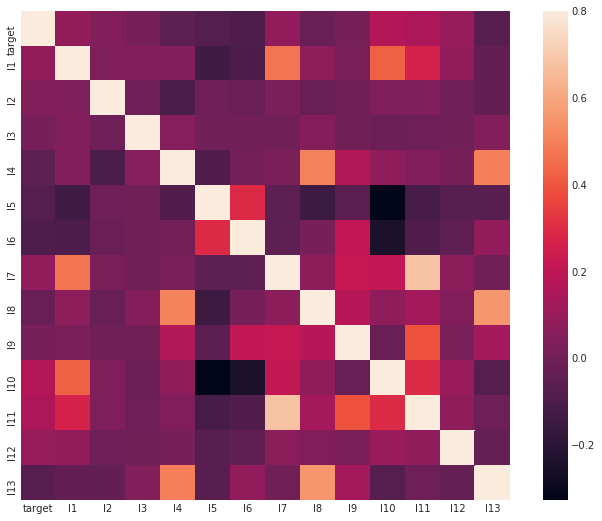

In [27]:
# correlation matrix of numeric features on sample data
numeric_data = sample.select(['target'] + numeric_features).toPandas()
corrmat = numeric_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

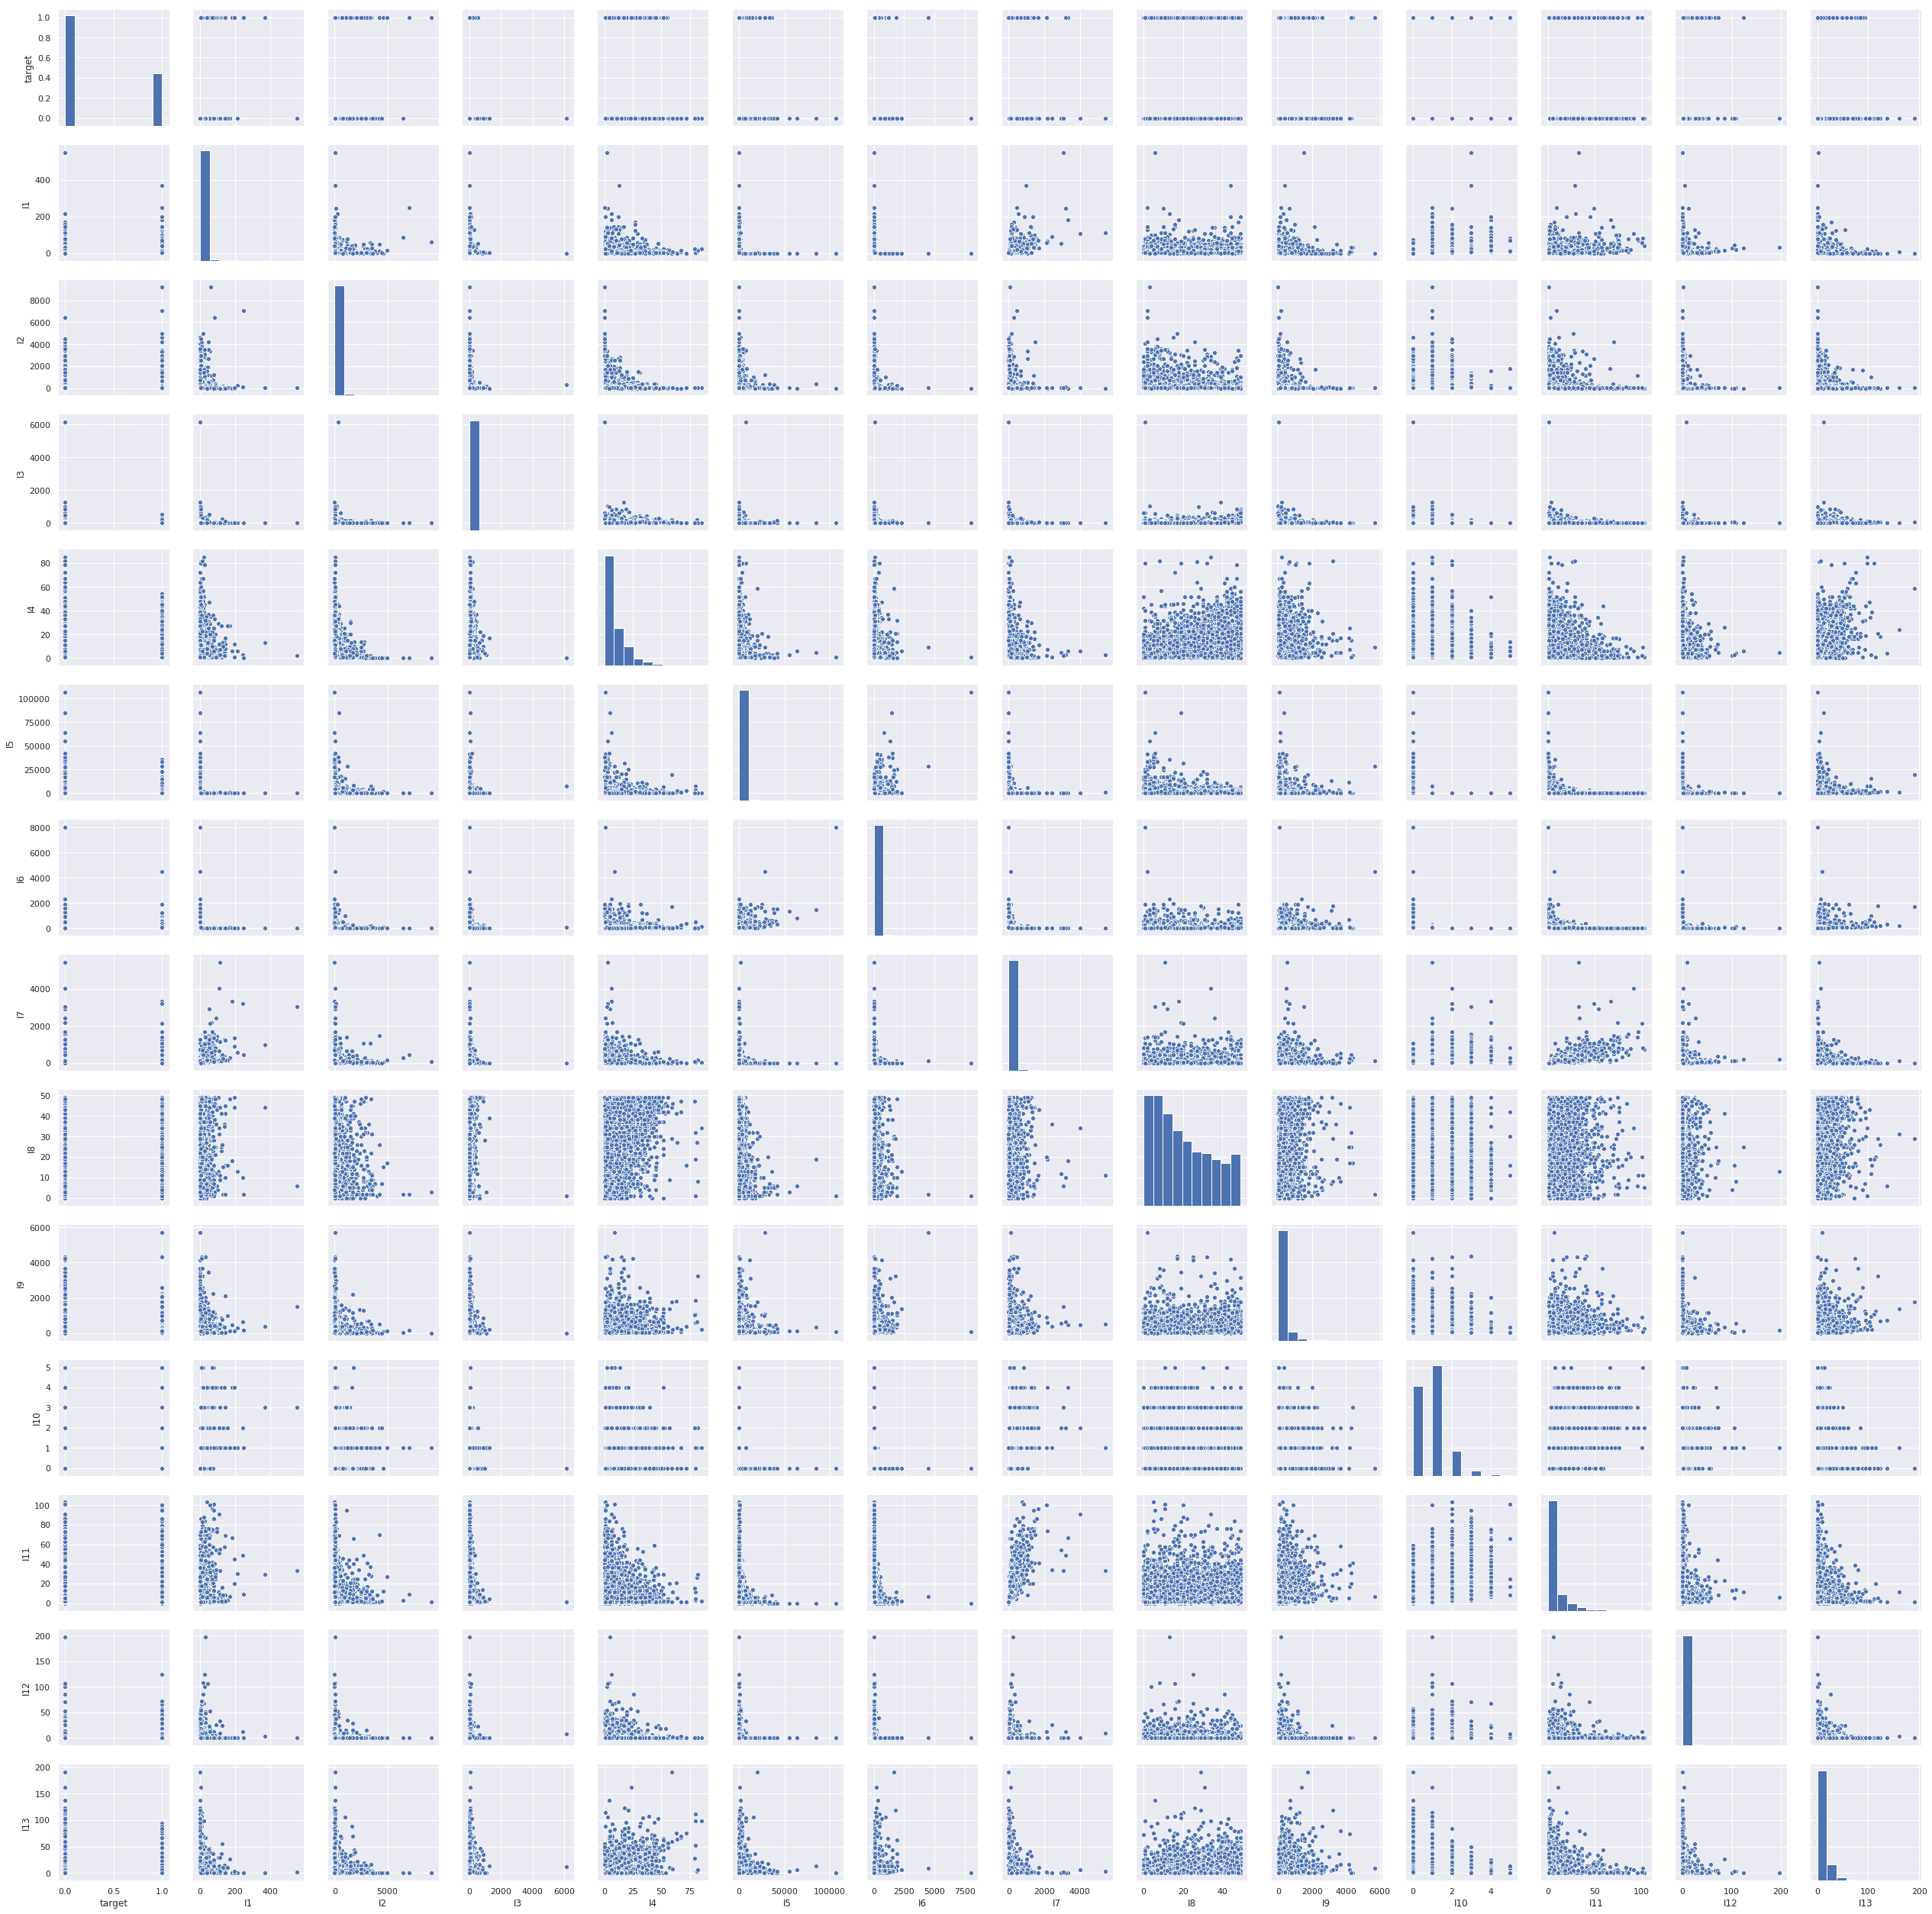

In [28]:
# scatterplot of numeric features
sample_pd = sample.toPandas()
sample_nona = sample_pd.dropna()
sns.set()
cols = ['target'] + numeric_features
sns.pairplot(sample_nona[cols], height = 2.5)
plt.show()

In [172]:
# look at summary statistics of categorical features in sample (levels, mode)
cat_summary = pd.DataFrame()
for i in categorical_features:
    cached = sample.groupBy(i).count().cache()
    mode = cached.orderBy('count', ascending=0).filter(i + "!=''").limit(1).toPandas()
    level = cached.count()
    mode['level'] = level
    mode['var'] = i
    mode.rename(columns={i:'mode'}, inplace=True)
    cat_summary = cat_summary.append(mode, ignore_index = True)
cat_summary

,mode,count,level,var
0,05db9164,229880,993,C1
1,38a947a1,52183,542,C2
2,d032c263,11414,181656,C3
3,c18be181,16378,79764,C4
4,25c83c98,309003,220,C5
5,7e0ccccf,182511,15,C6
6,1c86e0eb,9465,10479,C7
7,0b153874,272482,456,C8
8,a73ee510,412667,3,C9
9,3b08e48b,101627,23613,C10


Finally, we decide to do imputation on the missing values. For numeric features, we impute with mean values of non-missing values; for categorical features, we impute with mode of non-missing values.

In [214]:
# impute missing values - numeric features impute with mean, categorical features impute with mode
num_means = list(num_summary_pd['mean'].astype('float64').round().astype('int64'))
cat_modes = list(cat_summary['mode'])
impute = dict(zip(numeric_features+categorical_features, num_means+cat_modes))
impute

{'I1': 4,
 'I2': 106,
 'I3': 27,
 'I4': 7,
 'I5': 18539,
 'I6': 116,
 'I7': 16,
 'I8': 13,
 'I9': 106,
 'I10': 1,
 'I11': 3,
 'I12': 1,
 'I13': 8,
 'C1': '05db9164',
 'C2': '38a947a1',
 'C3': 'd032c263',
 'C4': 'c18be181',
 'C5': '25c83c98',
 'C6': '7e0ccccf',
 'C7': '1c86e0eb',
 'C8': '0b153874',
 'C9': 'a73ee510',
 'C10': '3b08e48b',
 'C11': '755e4a50',
 'C12': 'dfbb09fb',
 'C13': '5978055e',
 'C14': 'b28479f6',
 'C15': '2d0bb053',
 'C16': '84898b2a',
 'C17': 'e5ba7672',
 'C18': 'e88ffc9d',
 'C19': '21ddcdc9',
 'C20': 'b1252a9d',
 'C21': '0014c32a',
 'C22': 'ad3062eb',
 'C23': '32c7478e',
 'C24': '3fdb382b',
 'C25': '001f3601',
 'C26': '49d68486'}

In [15]:
# save imputation to file
# import json 
# json = json.dumps(impute)
# f = open("imputation_int.json","w")
# f.write(json)
# f.close()

# load json file
f = open("imputation_int.json")
impute = json.load(f)
f.close()

In [16]:
# impute missing and take a look at imputed data
train_df_impute = train_df.fillna(impute)
train_df_impute.cache()
pd.DataFrame(train_df_impute.take(10), columns=train_df_impute.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
target,0,0,0,0,0,0,0,1,0,0
I1,1,2,2,4,3,4,4,1,4,4
I2,1,0,0,893,-1,-1,1,4,44,35
I3,5,44,1,27,27,27,2,2,4,27
I4,0,1,14,7,0,7,7,0,8,1
I5,1382,102,767,4392,2,12824,3168,0,19010,33737
I6,4,8,89,116,0,116,116,0,249,21
I7,15,2,4,0,3,0,0,1,28,1
I8,2,2,2,0,0,0,1,0,31,2
I9,181,4,245,0,0,6,2,0,141,3


In [17]:
train_df_impute.printSchema()

root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = false)
 |-- I2: integer (nullable = false)
 |-- I3: integer (nullable = false)
 |-- I4: integer (nullable = false)
 |-- I5: integer (nullable = false)
 |-- I6: integer (nullable = false)
 |-- I7: integer (nullable = false)
 |-- I8: integer (nullable = false)
 |-- I9: integer (nullable = false)
 |-- I10: integer (nullable = false)
 |-- I11: integer (nullable = false)
 |-- I12: integer (nullable = false)
 |-- I13: integer (nullable = false)
 |-- C1: string (nullable = false)
 |-- C2: string (nullable = false)
 |-- C3: string (nullable = false)
 |-- C4: string (nullable = false)
 |-- C5: string (nullable = false)
 |-- C6: string (nullable = false)
 |-- C7: string (nullable = false)
 |-- C8: string (nullable = false)
 |-- C9: string (nullable = false)
 |-- C10: string (nullable = false)
 |-- C11: string (nullable = false)
 |-- C12: string (nullable = false)
 |-- C13: string (nullable = false)
 |-- C14: string (nullabl

<a id='algorithm_implementation'></a>
# 4. Algorithm Implementation

## Logistic Regression

In [62]:
numeric_features = ['I'+str(i) for i in [x for x in range(1, 14) if x != 12]] # drop I12 with 76% missing
categorical_features = ['C'+str(i) for i in [x for x in range(1, 27) if x != 22]] # drop C22 with 76% missing
#categorical_features = ['C6','C9','C14','C17','C20','C23','C25']

stages = []

for i in categorical_features:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol = i, outputCol = i + 'Index', handleInvalid="skip")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[i + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]
    
# Convert label into label indices using the StringIndexer
# label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')
# stages += [label_stringIdx]

# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Normalize
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
stages += [scaler]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_df_impute)
df = pipelineModel.transform(train_df_impute)
df.printSchema()

In [17]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
target,0,0,0,0,0
I1,1,2,2,4,3
I2,1,0,0,893,-1
I3,5,44,1,27,27
I4,0,1,14,7,0
I5,1382,102,767,4392,2
I6,4,8,89,116,0
I7,15,2,4,0,3
I8,2,2,2,0,0
I9,181,4,245,0,0


In [18]:
# train_df_impute.unpersist()
df.persist()
train_df_impute.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string]

In [23]:
# sc.setCheckpointDir('checkpoint/')
# df.checkpoint()

In [19]:
# split data into train and test sets
train, test = df.randomSplit([0.7, 0.3], seed = 666)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32089680
Test Dataset Count: 13750937


In [20]:
df.unpersist()
train.persist()
test.persist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, scaledFeatures: vector]

In [21]:
# fit logistic regression model
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'target', maxIter=10)
lrModel = lr.fit(train)

In [22]:
train.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, scaledFeatures: vector]

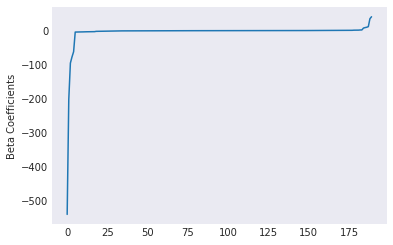

In [23]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
trainingSummary = lrModel.summary

In [24]:
# prediction
predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol = "target")

In [66]:
test.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, scaledFeatures: vector]

In [25]:
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.710480013975711


In [26]:
pd.DataFrame(predictions.take(5), columns=predictions.columns).transpose()

,0,1,2,3,4
target,0,0,0,0,0
I1,0,0,0,0,0
I2,-2,-2,-1,-1,-1
I3,9,201,0,0,1
I4,1,12,1,24,1
I5,7176,3299,7217,6438,6186
I6,171,171,116,174,214
I7,1,32,16,1,6
I8,35,16,1,29,12
I9,93,229,106,197,185


In [29]:
firstelement=udf(lambda v:float(v[0]),FloatType())

log_loss = (predictions.select(firstelement('probability').alias('probability'), 'target')\
    .withColumn('logloss', -f.col('target')*f.log(f.col('probability')) - (1.-f.col('target'))*f.log(1.-f.col('probability'))))

logloss = log_loss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
logloss

1.3428181287816991

In [30]:
# split variables
temp_var = testRDD.map(lambda x: x.split("\t"))

# creating header for data
numeric_features = ['I'+str(i) for i in range(1, 14)]
categorical_features = ['C'+str(i) for i in range(1, 27)]
header = numeric_features + categorical_features

# create pyspark dataframe
test_df = temp_var.toDF(header)

In [32]:
# cast integer variables to integer type
for var in numeric_features:
    test_df =test_df.withColumn(var, test_df[var].cast(IntegerType()))

# for some reason missing categorical variables are not recognized as NA, replacing with the None here
test_df = test_df.replace('', None, categorical_features)

In [101]:
# load json file
f = open("imputation_int.json")
impute = json.load(f)
f.close()

In [ ]:
# impute missing and take a look at imputed data
test_df_impute = test_df.fillna(impute)
test_df_impute.cache()

In [34]:
test_df_tr = pipelineModel.transform(test_df_impute)

In [35]:
test_df_tr.cache()
test_df_impute.unpersist()

DataFrame[I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string]

In [36]:
# prediction
test_predictions = lrModel.transform(test_df_tr)

In [37]:
test_predictions.cache()
test_df.unpersist()

DataFrame[I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string]

In [41]:
pred = test_predictions.select(firstelement('probability').alias('probability')).toPandas()
submission = pd.read_csv('random_submission.csv')
submission2 = pd.concat([submission['Id'], pred['probability']], axis=1)
submission2.rename(columns={'probability':'Predicted'}, inplace=True)
submission2.to_csv('predictions_lr.csv', index=False)

In [59]:
submission2.head()

,Id,Predicted
0,60000000,0.790273
1,60000001,0.869363
2,60000002,0.811100
3,60000003,0.779192
4,60000004,0.793049


## Gradient Boosted Tree

In [18]:
numeric_features = ['I'+str(i) for i in [x for x in range(1, 14) if x != 12]] # drop I12 with 76% missing
categorical_features = ['C'+str(i) for i in [x for x in range(1, 27) if x!=22 and x!=3 and x!=12 and x!=16 and x!=21]] # drop C22 with 76% missing
#categorical_features = ['C6','C9','C14','C17','C20','C23','C25']

stages = []

for i in categorical_features:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol = i, outputCol = i + 'Index', handleInvalid="skip")
    stages += [stringIndexer]

# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "Index" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Normalize
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
stages += [scaler]

# Index categorical features in feature vectors
indexer = VectorIndexer(inputCol="scaledFeatures", outputCol="indexedFeatures", maxCategories=50)
stages += [indexer]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_df_impute)
df = pipelineModel.transform(train_df_impute)
df.printSchema()

In [18]:
train_df_impute.unpersist()
df.cache()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector]

In [19]:
# split data into train and test sets
train, test = df.randomSplit([0.7, 0.3], seed = 666)
# print("Training Dataset Count: " + str(train.count()))
# print("Test Dataset Count: " + str(test.count()))

In [20]:
train.persist()
test.persist()
df.unpersist()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector]

In [21]:
# fit GBM
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'indexedFeatures', labelCol = 'target', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
train.unpersist()
test.unpersist()
predictions.cache()

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C1Index: double, C2Index: double, C4Index: double, C5Index: double, C6Index: double, C7Index: double, C8Index: double, C9Index: double, C10Index: double, C11Index: double, C13Index: double, C14Index: double, C15Index: double, C17Index: double, C18Index: double, C19Index: double, C20Index: double, C23Index: double, C24Index: double, C25Index: double, C26Index: double, features: vector, scaledFeatures: vector, indexedFeatures: vector, rawPrediction: vector, probability: vector, prediction: double]

In [22]:
predictions.select('target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[0.87662401617579...|       0.0|[0.85236200562961...|
|     0|[0.77584110687556...|       0.0|[0.82515656298019...|
|     0|[0.52571574947574...|       0.0|[0.74104969151318...|
|     0|[0.42545522189775...|       0.0|[0.70075809395574...|
|     0|[0.78902948361532...|       0.0|[0.82892944472018...|
|     0|[1.01223448096350...|       0.0|[0.88334231921258...|
|     0|[0.51428527745944...|       0.0|[0.73663867425247...|
|     0|[0.50302081729404...|       0.0|[0.73224477657962...|
|     0|[0.53453169664196...|       0.0|[0.74441875832713...|
|     0|[0.83581827657656...|       0.0|[0.84179389421962...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [24]:
import pyspark.sql.functions as f

secondelement=f.udf(lambda v:float(v[1]),FloatType())

log_loss = (predictions.select(secondelement('probability').alias('probability'), 'target')\
    .withColumn('logloss', -f.col('target')*f.log(f.col('probability')) - (1.-f.col('target'))*f.log(1.-f.col('probability'))))

logloss = log_loss.agg(f.mean('logloss').alias('ll')).collect()[0]['ll']
logloss

0.5100726544935856

## Random Forest

In [17]:
df.replace('', None, categorical_features)
with open("imputation_int.json") as json_file:  
    impute = json.load(json_file)
    del impute['C22']
    del impute['I12']
df_impute = df.replace('', None, categorical_features)
df_impute = df_impute.fillna(impute)

hex_string=udf(lambda x:int(x,16),IntegerType())

for col in categorical_features:
    df_impute = df_impute.withColumn(col,hex_string(col))

In [18]:
def preprocess(df):
    stages = []
#     categorical_features_index=[]
#    ['C1','C2','C5','C6','C8','C9','C11','C13','C14','C15','C17','C18','C19','C20','C22','C23','C25']
#     for categoricalCol in categorical_features:
#         stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#         encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#         #encoder = VectorIndexer(inputCol=[stringIndexer.getOutputCol()], outputCol=[categoricalCol + "classVec"])
#         categorical_features_index += [categoricalCol + 'Index']
#         stages += [stringIndexer,encoder]
    #print(categorical_features_index)

    vector_assembler = VectorAssembler( \
        inputCols= numeric_features+ categorical_features, \
        outputCol="features")

    stages += [vector_assembler] 
    pipeline = Pipeline(stages = stages)

    pipelineModel = pipeline.fit(df)
    df_temp = pipelineModel.transform(df)
    
    return df_temp, pipelineModel


In [19]:
start = time.time()
df_temp, pipelineModel = preprocess(df_impute)
print("Wall time: {} seconds".format(time.time() - start))
df_temp.printSchema()

Wall time: 0.02083730697631836 seconds
root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = false)
 |-- I2: integer (nullable = false)
 |-- I3: integer (nullable = false)
 |-- I4: integer (nullable = false)
 |-- I5: integer (nullable = false)
 |-- I6: integer (nullable = false)
 |-- I7: integer (nullable = false)
 |-- I8: integer (nullable = false)
 |-- I9: integer (nullable = false)
 |-- I10: integer (nullable = false)
 |-- I11: integer (nullable = false)
 |-- I13: integer (nullable = false)
 |-- C1: integer (nullable = true)
 |-- C2: integer (nullable = true)
 |-- C3: integer (nullable = true)
 |-- C4: integer (nullable = true)
 |-- C5: integer (nullable = true)
 |-- C6: integer (nullable = true)
 |-- C7: integer (nullable = true)
 |-- C8: integer (nullable = true)
 |-- C9: integer (nullable = true)
 |-- C10: integer (nullable = true)
 |-- C11: integer (nullable = true)
 |-- C12: integer (nullable = true)
 |-- C13: integer (nullable = true)
 |-- C14: integer (null

In [10]:
(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
start = time.time()
rf = RandomForestClassifier(labelCol="target",\
featuresCol="features", numTrees=100)
model = rf.fit(trainingData)

predictions = model.transform(testData)
evaluator = BinaryClassificationEvaluator(labelCol = "target")

print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
print("Wall time: {} seconds".format(time.time() - start))

Test Area Under ROC: 0.7083715760474067
Wall time: 3488.9581015110016 seconds


In [38]:
predictions

DataFrame[target: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, C6Index: double, C6classVec: vector, C9Index: double, C9classVec: vector, C14Index: double, C14classVec: vector, C17Index: double, C17classVec: vector, C20Index: double, C20classVec: vector, C23Index: double, C23classVec: vector, C25Index: double, C25classVec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [27]:
predictions.select('target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     0|[85.9569560005486...|       0.0|[0.85956956000548...|
|     0|[81.0723273102391...|       0.0|[0.81072327310239...|
|     0|[76.8602831987373...|       0.0|[0.76860283198737...|
|     0|[84.1087912534379...|       0.0|[0.84108791253437...|
|     0|[79.3108344510999...|       0.0|[0.79310834451099...|
|     0|[75.0067298049367...|       0.0|[0.75006729804936...|
|     0|[81.5320252434899...|       0.0|[0.81532025243489...|
|     0|[81.3178605316716...|       0.0|[0.81317860531671...|
|     0|[78.7006942259489...|       0.0|[0.78700694225948...|
|     0|[84.2800906835654...|       0.0|[0.84280090683565...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import math

def logloss(prob, actual):
    if actual == 1:
        return -math.log(prob)
    else:
        return -math.log(1-prob)

udf_logloss = udf(logloss, FloatType())

firstelement=udf(lambda v:float(v[1]),FloatType())
logloss = predictions.select(firstelement('probability').alias('probability'), 'target').withColumn("logloss", udf_logloss("probability","target"))\
       .groupby().avg('logloss').collect()
print (logloss)


[Row(avg(logloss)=0.5186227341338779)]


In [20]:
rdd_test = sc.textFile("./data/test.txt")
numeric_features = ['I'+str(i) for i in range(1, 14)]
categorical_features = ['C'+str(i) for i in range(1, 27)]
header_test = numeric_features + categorical_features
df_test = rdd_test.map(lambda x: x.split("\t")).toDF(header_test).cache()

for var in numeric_features:
    df_test =df_test.withColumn(var, df_test[var].cast(IntegerType()))
    
df_test.replace('', None, categorical_features)
with open("imputation_int.json") as json_file:  
    impute = json.load(json_file)
df_impute_test=df_test.replace('', None, categorical_features)
df_impute_test = df_impute_test.fillna(impute)

hex_string=udf(lambda x:int(x,16),IntegerType())

for col in categorical_features:
    df_impute_test = df_impute_test.withColumn(col,hex_string(col))

df_temp_test = pipelineModel.transform(df_impute_test)

predictions_test = model.transform(df_temp_test)

In [25]:
pred = predictions_test.select(firstelement('probability').alias('Predicted')).toPandas()
submission = pd.read_csv('random_submission.csv')
submission2 = pd.concat([submission['Id'], pred['Predicted']], axis=1)
#submission2.rename(columns={'probability':'Predicted'}, inplace=True)
submission2.to_csv('predictions_rf3.csv', index=False)

In [26]:
submission2.head()

,Id,Predicted
0,60000000,0.179017
1,60000001,0.272029
2,60000002,0.355309
3,60000003,0.183668
4,60000004,0.333123


<a id='course_concepts_application'></a>
# 5. Application of Course Concepts

## Lazy Evaluation

Lazy evaluation is an evaluation strategy in programming to delay the the evaluation of an expression until its value is needed. This is effective in preventing repeated computation of the same expression. Sparks employs this strategy in its evaluation of data stored in the form of RDDs and does not initiate the execution of transformations until an action is triggered. It is quite possible that one has executed several cells in their Jupyter Notebook but the data may have remained as is if the cells executed have not reached any action.

We needed to be mindful of this concept for the course of this project as we used Spark heavily throughout the project. It was perhaps even more prevalent during the earlier phases of the project when we were conducting EDA and feature engineering and applying various transformations to the dataset in dissecting and preparing them for subsequent machine learning algorithmic analysis. As the dataset we were working with was relatively large, each transformation takes a long time and we would often try out the transformation on a smaller sample to see how well our machines can handle the workload. Failing to recognize the lazy evaluating nature of of Spark can cause us to incorrectly assess the time and computational resources required in completing the work.

## One Hot Encoding

One hot encoding is a representation of categorical variables as binary vectors. Most machine learning algorithms are unable to work with non-numerical values as is and hence they need to be converted into a form that is machine learning algorithm-friendly.

This usually happens in the below 2 steps:

1. Map categorical values to integer values
2. Convert each integer value to a binary vector which consists of zero values except the index of the integer marked with a 1

In the dataset were given to work with, we identified the first 14 columns to be numerical and the remaining 25 to be categorical. During our featuring engineering phase, we used MLlib’s StringIndexer and OneHotEncoder functions respectively for each step in one hot encoding the categorical features in order to make them compatible with the machine learning algorithms such as Logistic Regression.

## Gradient Descent

Gradient Descent is an optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. For our logistic regression implementation, Stochastic Gradient Descent (SGD) computes the gradient for each update using a single training data point at random. The idea is that the gradient calculated this way is a stochastic approximation to the gradient calculated using the entire trainng data. Each update is much faster to calculate than in batch gradient descent, and over many updates, we will head in the same direction.